In [2]:
# Подключение необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dtime
import matplotlib.pyplot as plt
import scipy.stats as stats
from ydata_profiling import ProfileReport
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

### Получение исходных данных

In [3]:
df = pd.read_csv('../datasets/gym_churn.csv')

### Исследовательский анализ данных (EDA)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [10]:
ProfileReport(df, minimal=True) # Формирования отчета для исследования данных

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


In [11]:
df.mean()

gender                                 0.510250
Near_Location                          0.845250
Partner                                0.486750
Promo_friends                          0.308500
Phone                                  0.903500
Contract_period                        4.681250
Group_visits                           0.412250
Age                                   29.184250
Avg_additional_charges_total         146.943728
Month_to_end_contract                  4.322750
Lifetime                               3.724750
Avg_class_frequency_total              1.879020
Avg_class_frequency_current_month      1.767052
Churn                                  0.265250
dtype: float64

In [12]:
df.groupby(by='Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [13]:
left = df.query("Churn == 1")
stay = df.query("Churn == 0")

In [14]:
def col(i):
    pvt = pd.pivot_table(data=df, 
                          index="Churn", 
                          columns = df.iloc[:,i],
                          values='Age',
                          aggfunc='count').reset_index()
    pvt.columns=['Churn', df.columns[i]+'_0', df.columns[i]+'_1']
    m = plt.bar(x = pvt['Churn']-0.1, height = pvt.iloc[:,1], width=0.2, label = pvt.columns[1])
    w = plt.bar(x = pvt['Churn']+0.1, height = pvt.iloc[:,2], width=0.2, label = pvt.columns[2])
    plt.xticks(ticks=[0,1], labels=['остались', 'отток'])
    plt.legend()
    plt.bar_label(m)
    plt.bar_label(w)
    plt.show()

In [15]:
category_cols = pd.Series([0,1,2,3,4,6])

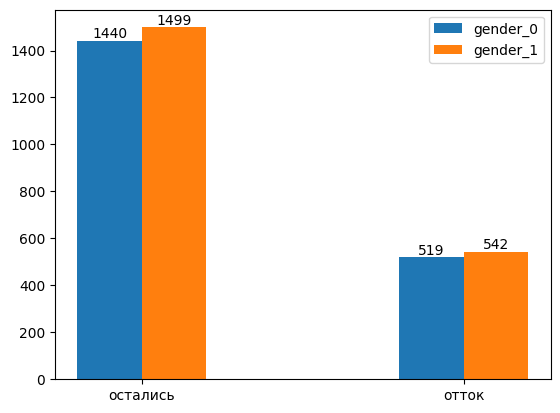

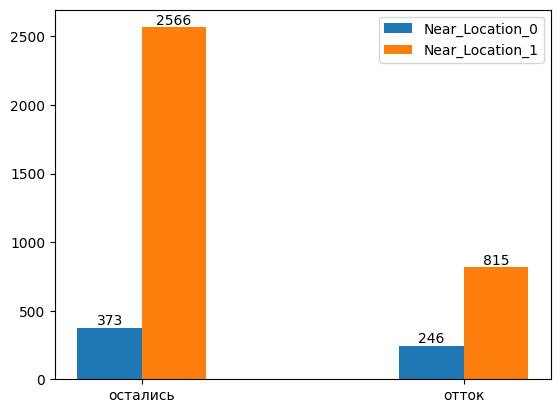

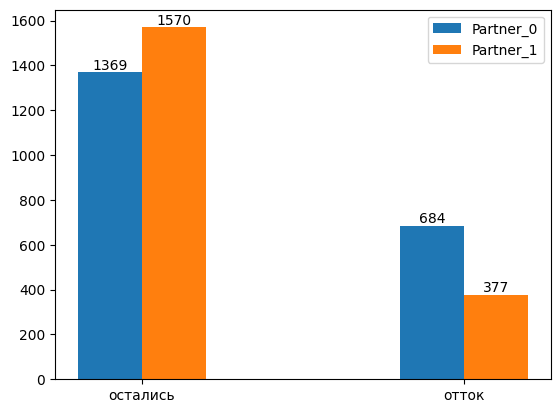

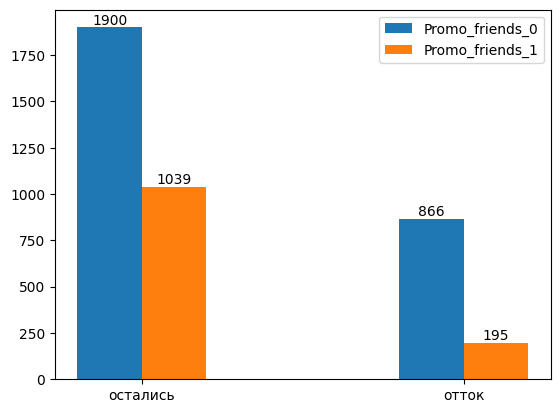

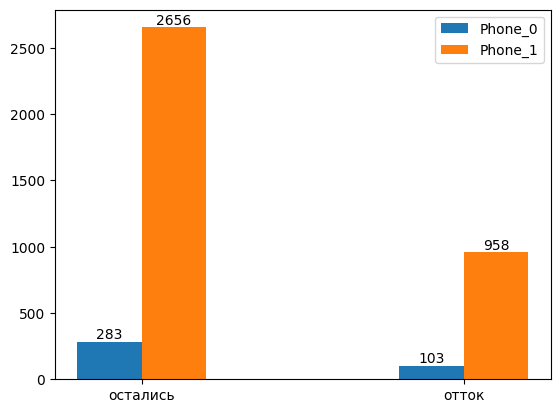

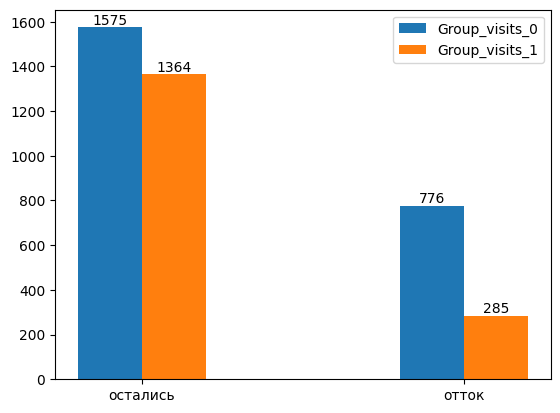

In [16]:
for i in category_cols:
    col(i)

### Клиенты, работающие в копаниях-партнерах более лоялны.

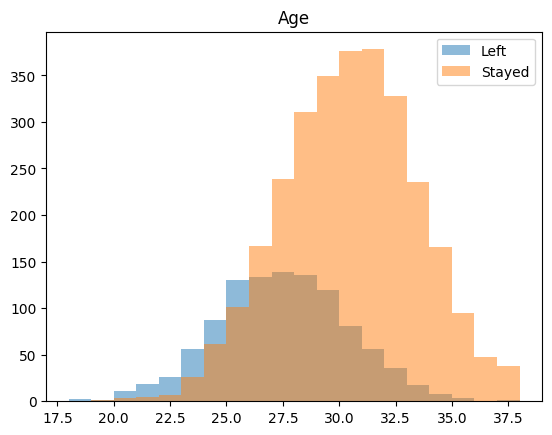

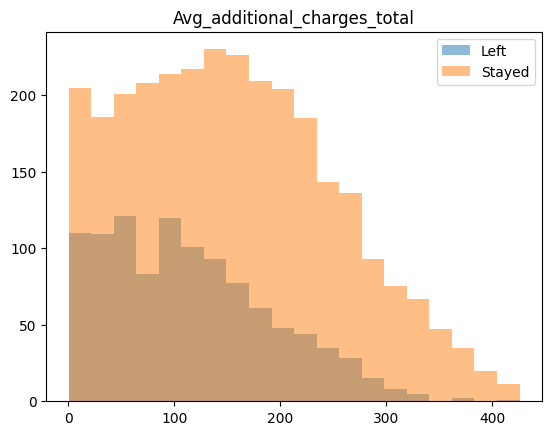

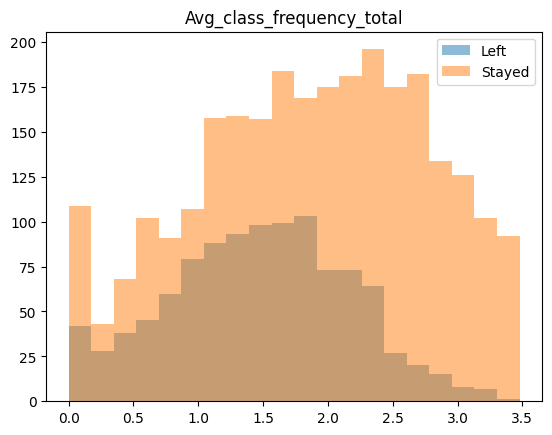

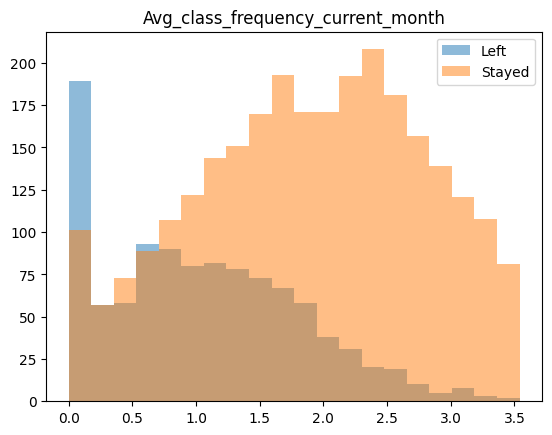

In [17]:
category_cols_2 = pd.Series([7,8,11,12])

for i in category_cols_2:
    n, bins, patches = plt.hist(left.iloc[:,i], bins = 20, alpha= 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], bins = bins, alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

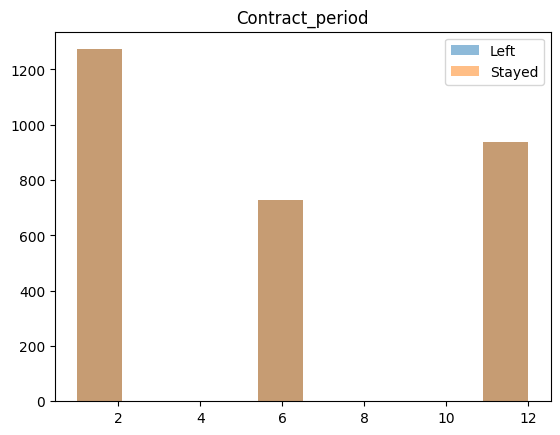

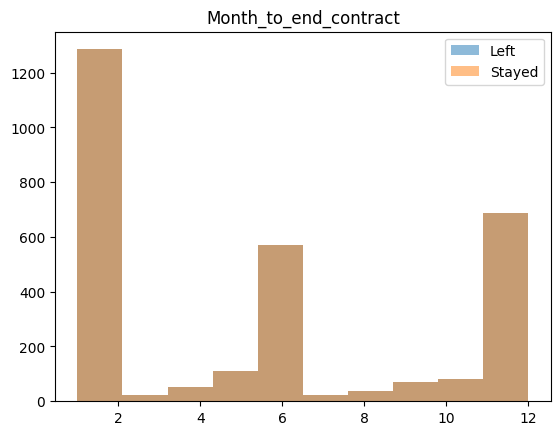

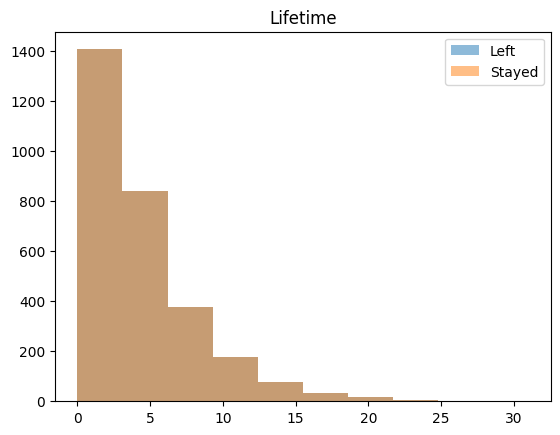

In [34]:
category_cols_3 = pd.Series([5,9,10])

for i in category_cols_3:
    plt.hist(stay.iloc[:,i], alpha = 0.5, label = 'Left')
    plt.hist(stay.iloc[:,i], alpha = 0.5, label = 'Stayed')
    plt.legend()
    plt.title(left.columns[i])
    plt.show()

<Axes: >

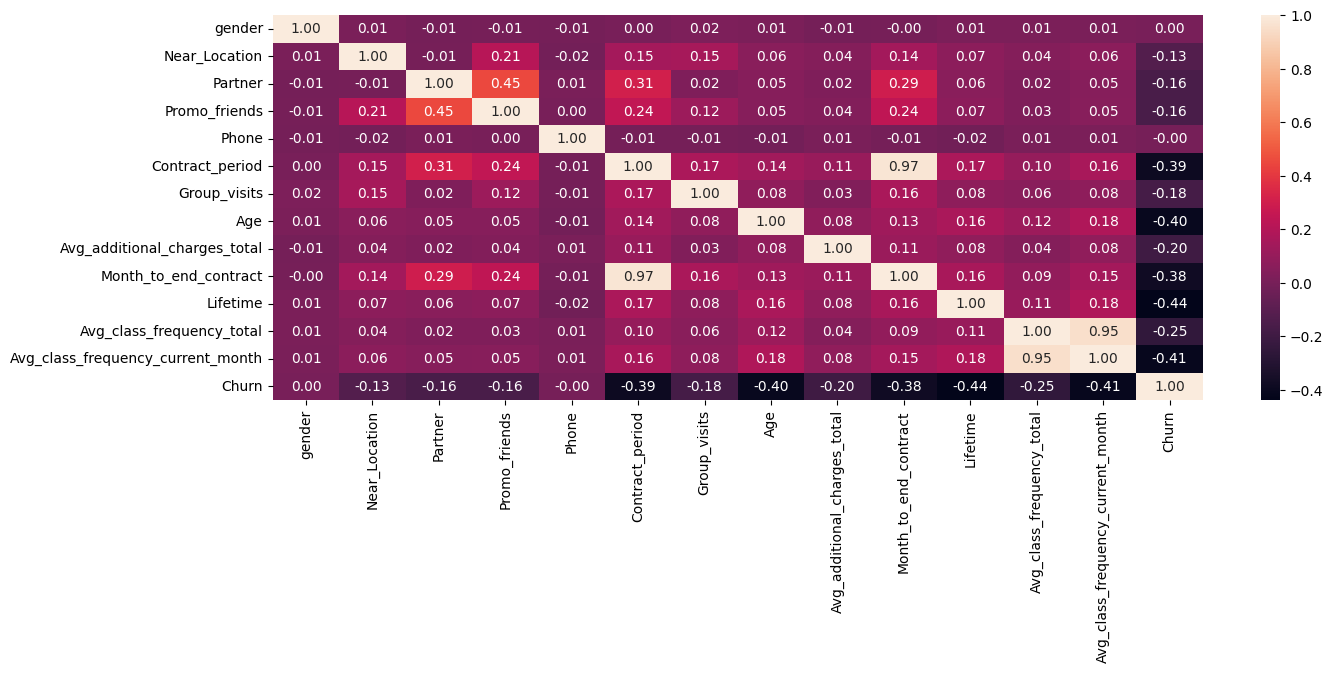

In [18]:
correl = df.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(correl, annot=True, fmt = ".2f")

### Формирование прогнозной модели на основе ...

In [20]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print(acc, precision, recall)

0.92375 0.8586387434554974 0.8282828282828283


### Формирование прогнозной модели на основе ...

In [21]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)

0.91 0.8315789473684211 0.797979797979798


### Категоризация клиентов

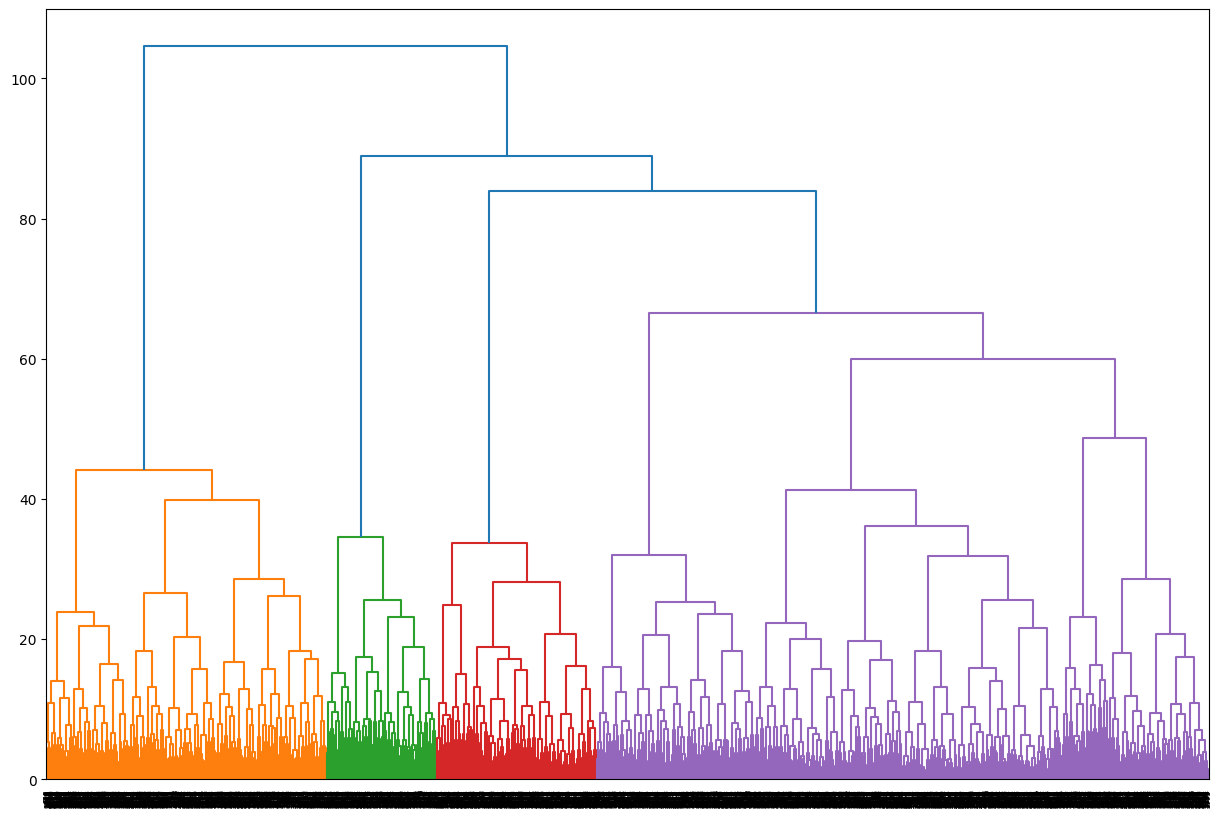

In [23]:
sc = StandardScaler()
X_sc =sc.fit_transform(X)

linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15,10))

dendrogram(linked, orientation='top')
plt.show()

### Кластеризация

In [25]:
cl = 4
km = KMeans(n_clusters=cl)
labels = km.fit_predict(X_sc)

In [26]:
df['cluster'] = labels

In [27]:
pvtt = pd.pivot_table(data = df,
                      index = 'cluster',
                      columns = 'Churn',
                      values='Age',
                      aggfunc='count').reset_index()
pvtt.columns = ['cluster', 'Churn_0', 'Churn_1']

pvtt['perc'] = pvtt['Churn_1'] / (pvtt['Churn_0'] + pvtt['Churn_1'])
pvtt['number'] = pvtt['Churn_1'] + pvtt['Churn_0']

print(pvtt.head())

   cluster  Churn_0  Churn_1      perc  number
0        0      972      105  0.097493    1077
1        1      724       15  0.020298     739
2        2      655       46  0.065621     701
3        3      588      895  0.603506    1483


Доля оттока существенно изменяется по кластерам

In [28]:
left = df.query('Churn == 1')
stay = df.query('Churn == 0')

In [29]:
category_cat = pd.Series(np.arange(0,cl,1))
print(category_cat)
print(category_cols_2)

0    0
1    1
2    2
3    3
dtype: int32
0     7
1     8
2    11
3    12
dtype: int64


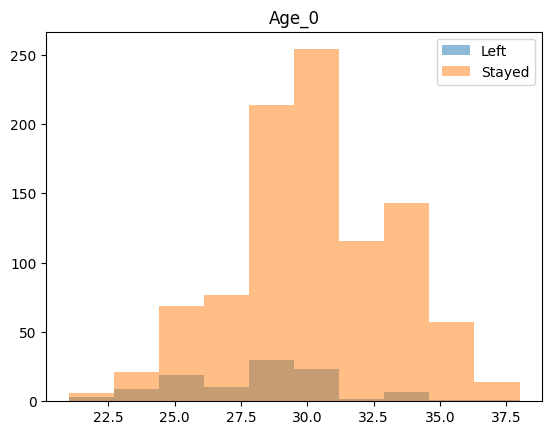

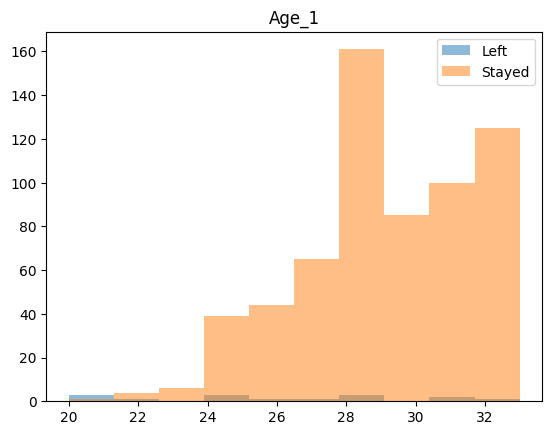

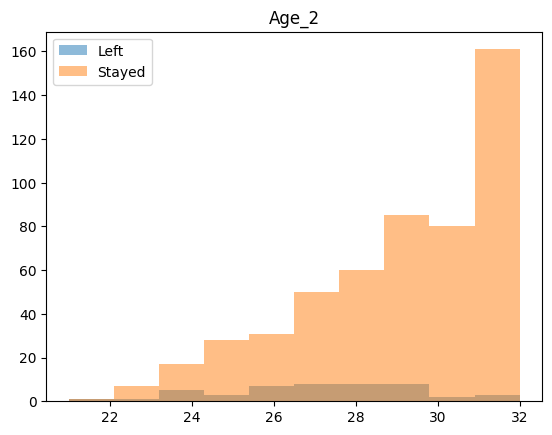

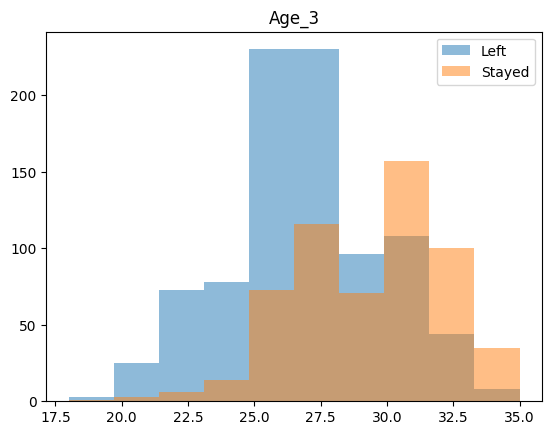

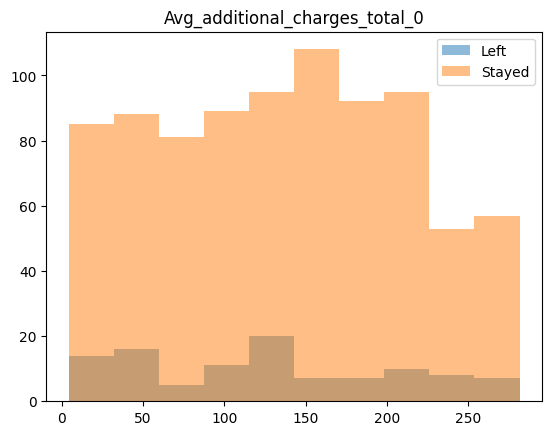

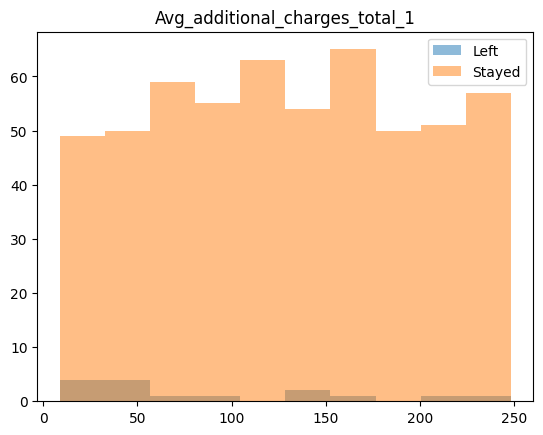

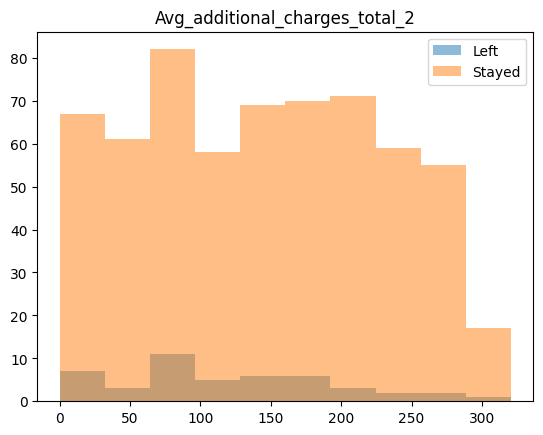

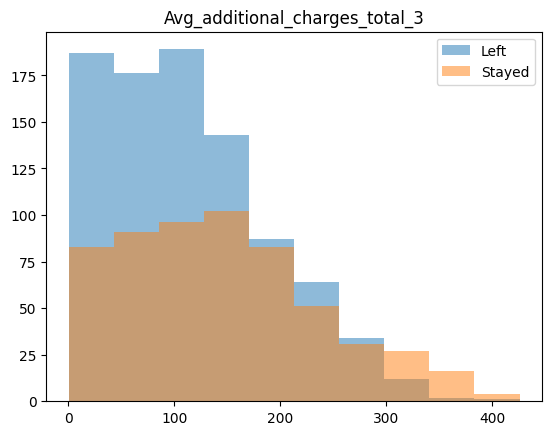

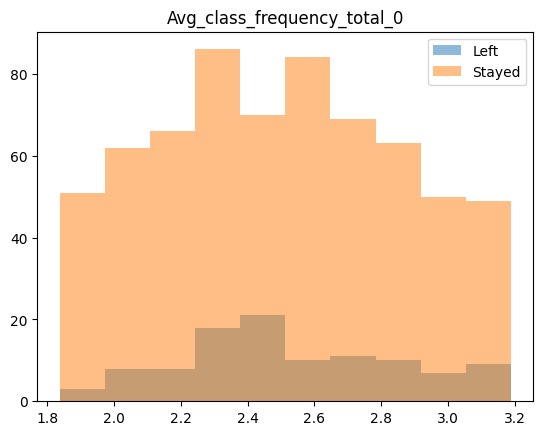

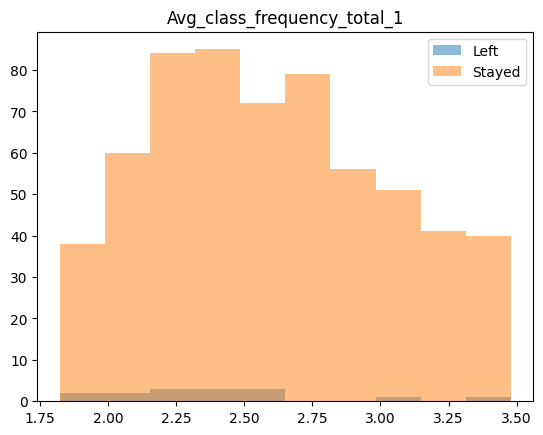

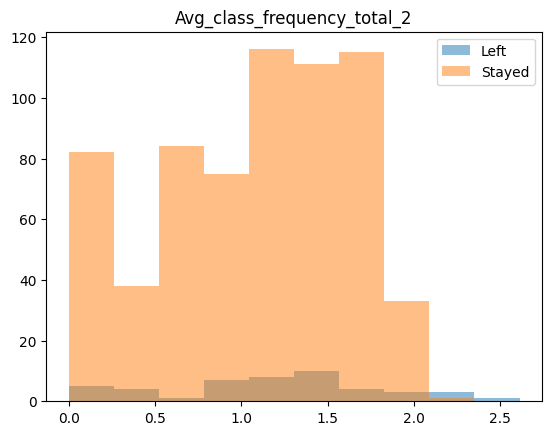

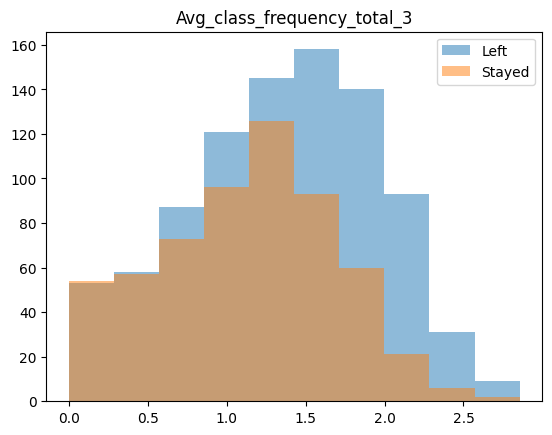

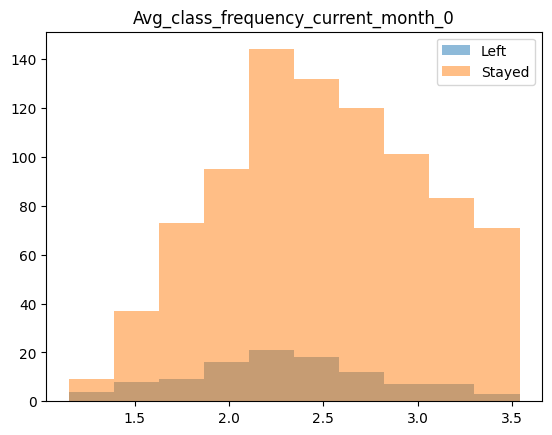

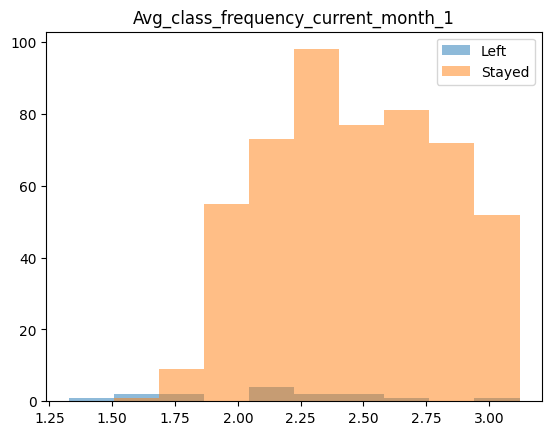

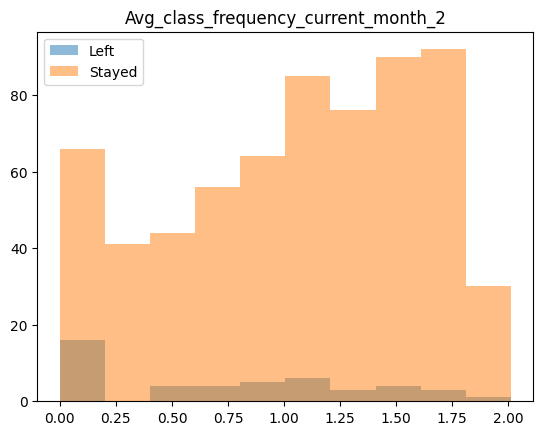

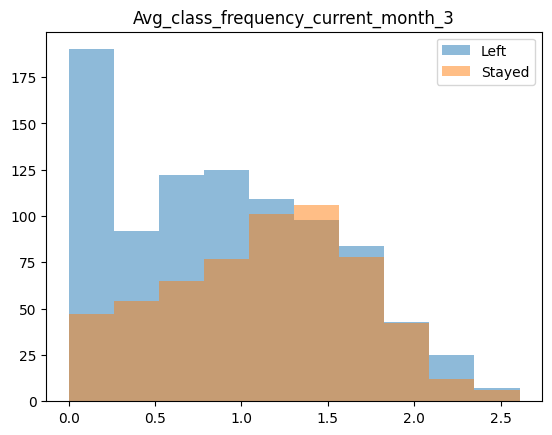

In [38]:
for i in category_cols_2:
    for j in category_cat:
        n, bins, patches = plt.hist(left[left['cluster'] == j].iloc[:,i],
                                    bins=10,
                                    alpha=0.5,
                                    label='Left')
        
        plt.hist(stay[stay['cluster'] == j].iloc[:,i], 
                 bins=bins,
                 alpha=0.5,
                 label='Stayed')
        
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

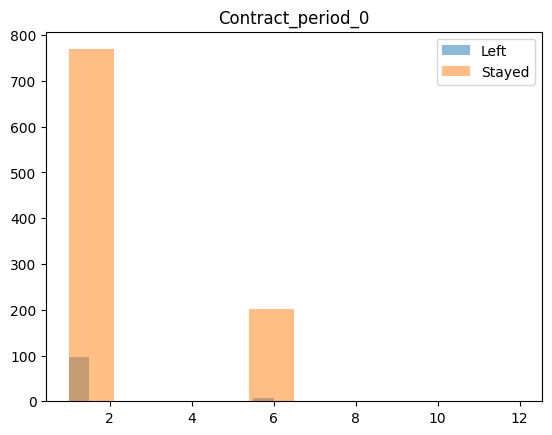

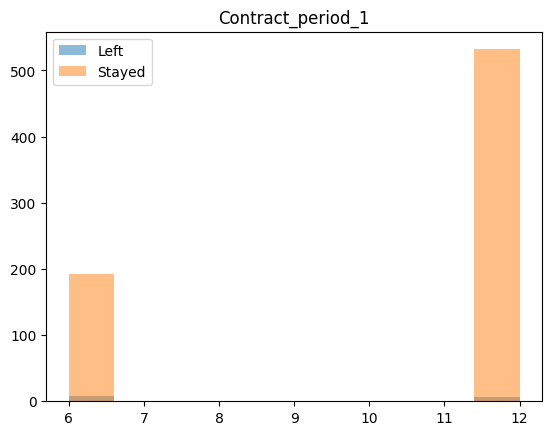

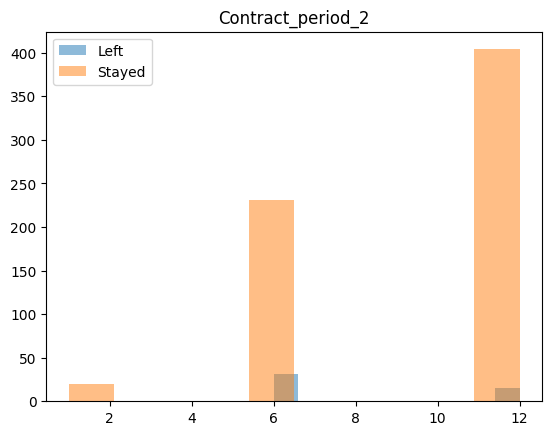

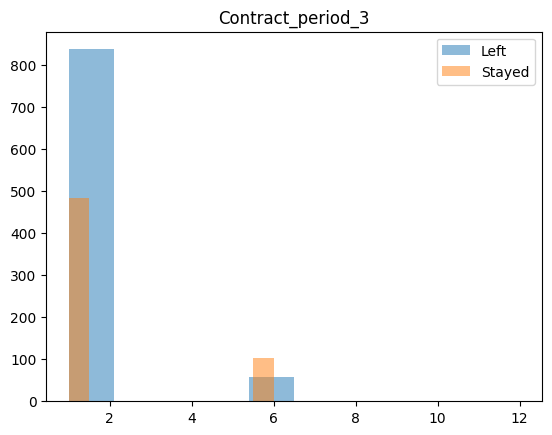

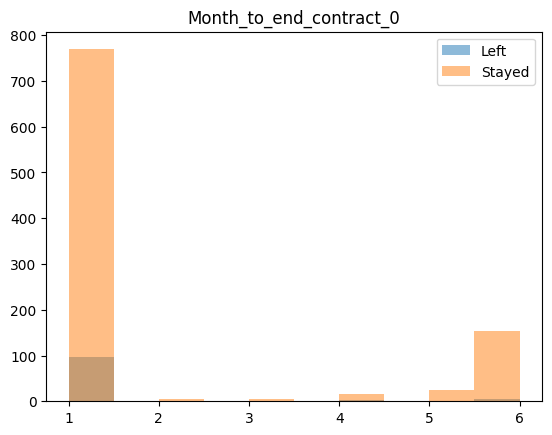

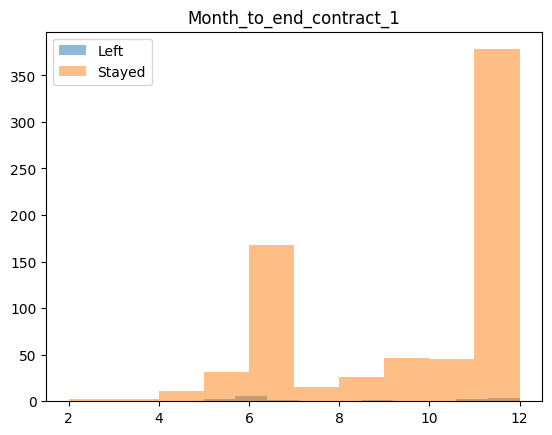

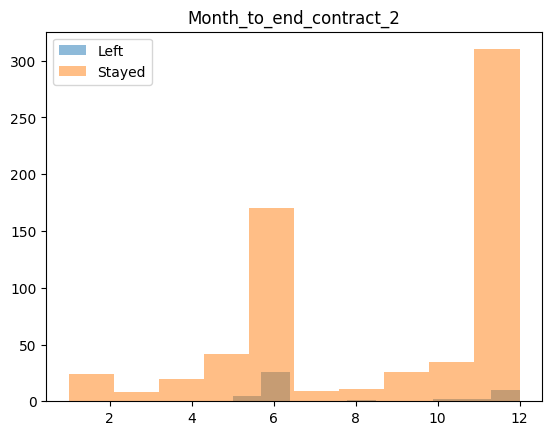

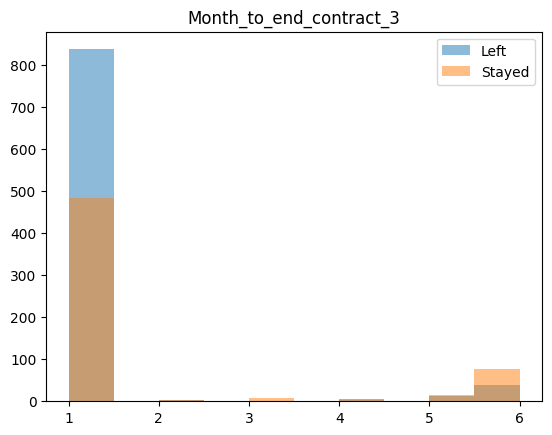

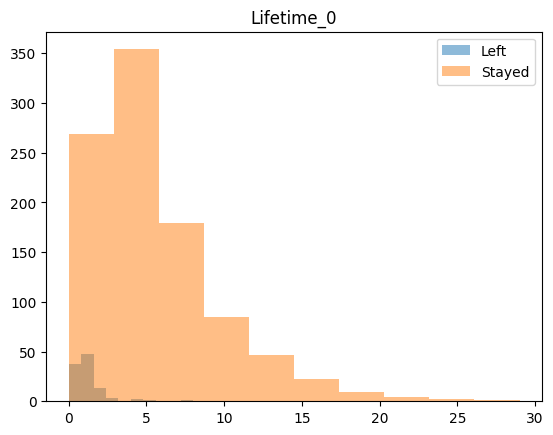

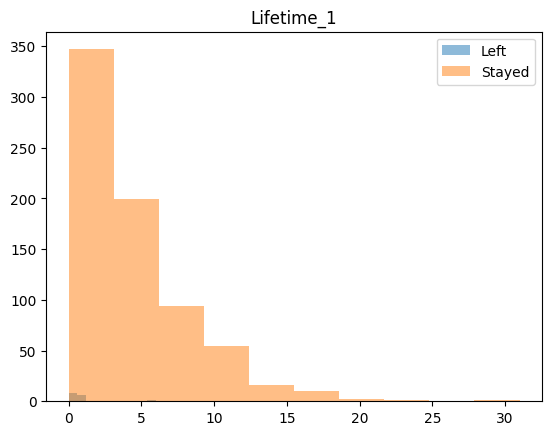

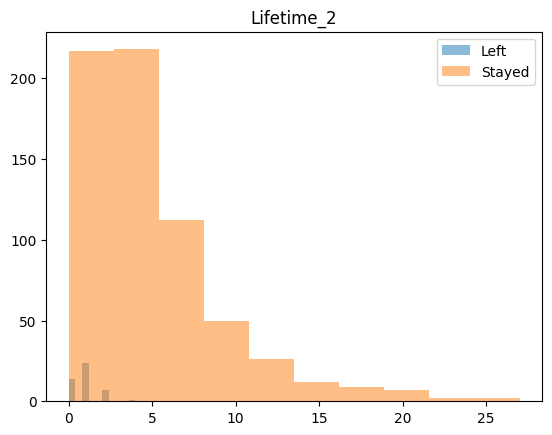

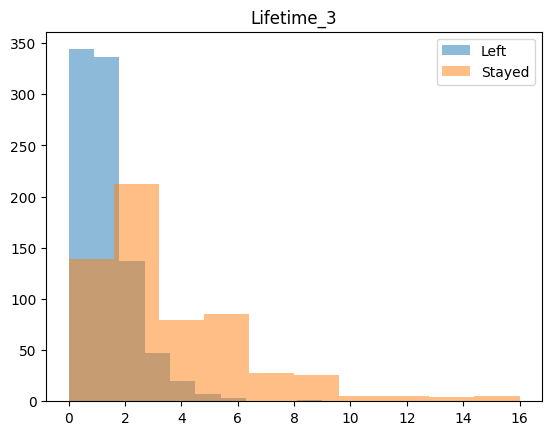

In [35]:
for i in category_cols_3:
    for j in category_cat:
        plt.hist(left[left['cluster'] == j].iloc[:,i], alpha=0.5, label='Left')
        plt.hist(stay[stay['cluster'] == j].iloc[:,i], alpha=0.5, label='Stayed')
        
        plt.legend()
        plt.title(left.columns[i]+'_%i' %j)
        plt.show()

In [43]:
for i in category_cols:
    for j in category_cat:
        pvt = pd.pivot_table(data=df[df['cluster'] == j],
                             index='Churn',
                             columns=df.iloc[:,i],
                             values='Age',
                             aggfunc='count')
        print(pvt.columns)
        print(pvt.shape)
        
        pvt.columns = ['Churn', df.columns[i]+'_0', df.columns[i]+'_1']
        
        m = plt.bar(x = pvt['Churn']-0.1,
                    height=pvt.iloc[:,1],
                    width=0.2,
                    label=pvt.columns[1])
        
        w = plt.bar(x = pvt['Churn']+0.1,
                    height=pvt.iloc[:,2],
                    width=0.2,
                    label=pvt.columns[2])
        
        plt.xticks(ticks=[0,1], labels=['остались', 'отток'])
        plt.legends()
        plt.bar_label(m)
        plt.bar_label(w)
        plt.title(df.columns[i]+'_%i' %j)
        plt.show()

Index([0, 1], dtype='int64', name='gender')
(2, 2)


ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

<Axes: >

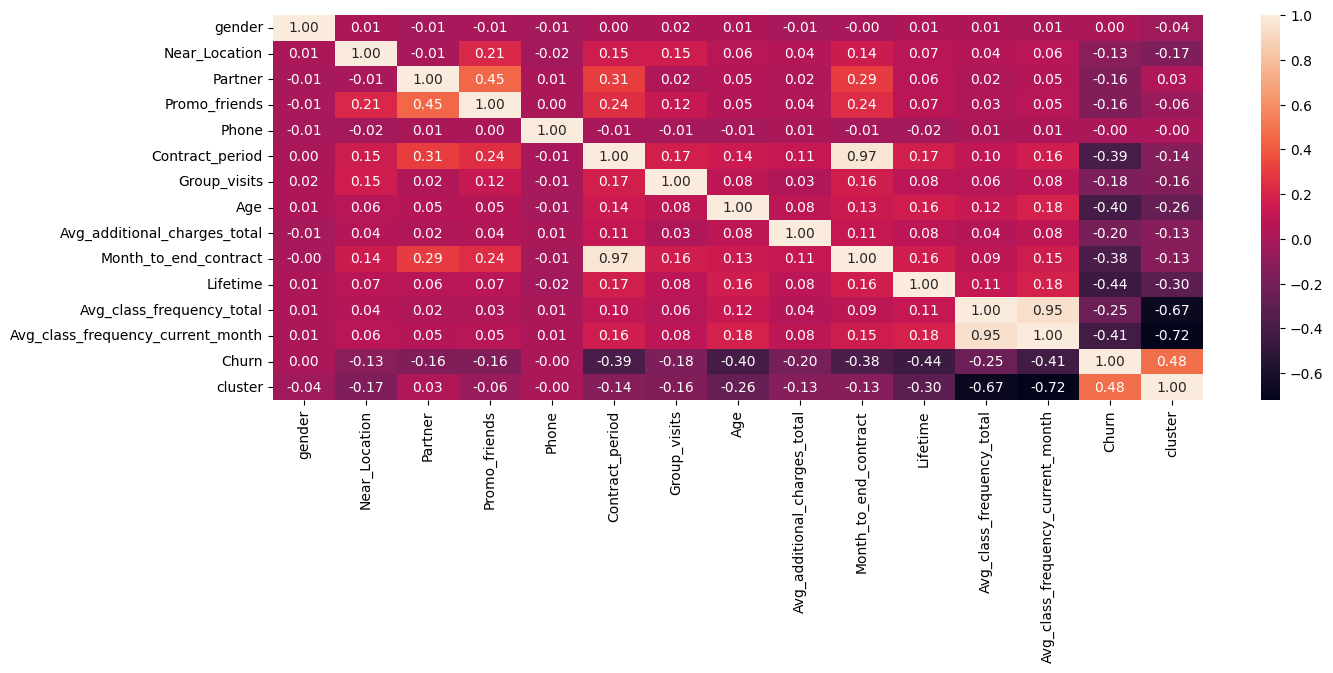

In [44]:
cor = df.corr()
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cor, annot = True, fmt='.2f')

In [45]:
df.groupby(by='cluster').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.551532,0.883937,0.273909,0.205200,0.903435,1.985144,0.460539,30.031569,156.863148,1.895079,4.814299,2.623680,2.607869,0.097493
1,0.465494,0.913396,0.772666,0.500677,0.914750,10.376184,0.487145,29.884980,161.439138,9.408660,4.669824,2.792176,2.788840,0.020298
2,0.560628,0.947218,0.774608,0.567760,0.881598,9.443652,0.574893,29.813124,158.380206,8.684736,4.697575,1.077210,1.050160,0.065621
3,0.478759,0.734997,0.362778,0.165206,0.908294,1.550236,0.262980,27.922454,127.110757,1.489548,2.002697,1.262194,0.986121,0.603506
